# EE5561 final project demo
### Group members: Rafael Avelar, Justin Bueno, Antonio Jimenez


Our project trained a neural network to perform segmentation on the BRATS2020 dataset. The project's aim was to develop a network architecture that could efficiently segment downsampled inputs. Our baseline architecture used a UNET combined with a VAE decoder, as a form of regularization. We experimented with many variations of this, and conducted a through ablation study and hyperparameter search to find out the impact of the VAE. 

This notebook is meant to reproduce the major results of our project. It will provide example results for baseline network, and two variations. We load three different pre-trained models and use them to segment three example volumes. 

The BRATS dataset provides anatomical MRI scans using 4 different contrasts, and brain tumor masks for 3 different tumore classes. In our results, we display only one modality of one slice of the volume, for succinctness. The multi-class segmentation results are displayed RGB images, with Red, Green and Blue corresponding to each of the three tumor classes. For each segmentation result, we report the corresponding Dice coefficient for each class.

First, import libraries and auxiliary functions:

In [1]:
import gdown
from pathlib import Path
from demo_utils import *
from src.data_preparation import BRATS_dataset

Next, we import three different models and three multi-model MRI volumes from Google Drive into a folder demo_data

In [2]:
import gdown

url = "https://drive.google.com/file/d/1JyIggddXABuMlS9J66-ePDizilIRGrWF/view?usp=drive_link"
gdown.download(url, "demo_data.zip", fuzzy=True)

# unzip it
!unzip demo_data.zip -d demo_data

Downloading...
From (original): https://drive.google.com/uc?id=1JyIggddXABuMlS9J66-ePDizilIRGrWF
From (redirected): https://drive.google.com/uc?id=1JyIggddXABuMlS9J66-ePDizilIRGrWF&confirm=t&uuid=76e47a4a-9844-4f01-93e6-2593935b213e
To: /users/0/avela019/Desktop/EE5561_project/EE5561_project_final/demo_data.zip
100%|██████████| 443M/443M [00:03<00:00, 137MB/s]  


Archive:  demo_data.zip
Written using ZipKit 6.3.1
   creating: demo_data/.ipynb_checkpoints/
   creating: demo_data/BraTS20_Training_001/
  inflating: demo_data/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: demo_data/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: demo_data/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: demo_data/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: demo_data/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
   creating: demo_data/BraTS20_Training_002/
  inflating: demo_data/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: demo_data/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: demo_data/BraTS20_Training_002/BraTS20_Training_002_t1.nii  
  inflating: demo_data/BraTS20_Training_002/BraTS20_Training_002_t1ce.nii  
  inflating: demo_data/BraTS20_Training_002/BraTS20_Training_002_t2.nii  
   creating: demo_data/BraTS20_Training_296/
  inflating: demo_d

### Example 1: Reference network architecture

As a baseline, we segment full-resolution images using the reference network architecture. The only change to the netowrk training procedure done in this case is a learning rate search, since we found that the original learning rate was too high.

Note that in this case, the VAE output is quite blurry. This is because the KL divergence term in the loss function has a relatively large weight, which we chose following the reference paper. Here, both the MSE and KL divergence loss have weight  = 0.1. We found that this is not necessarily optimal.


Plotting results------------------------------------------------------------


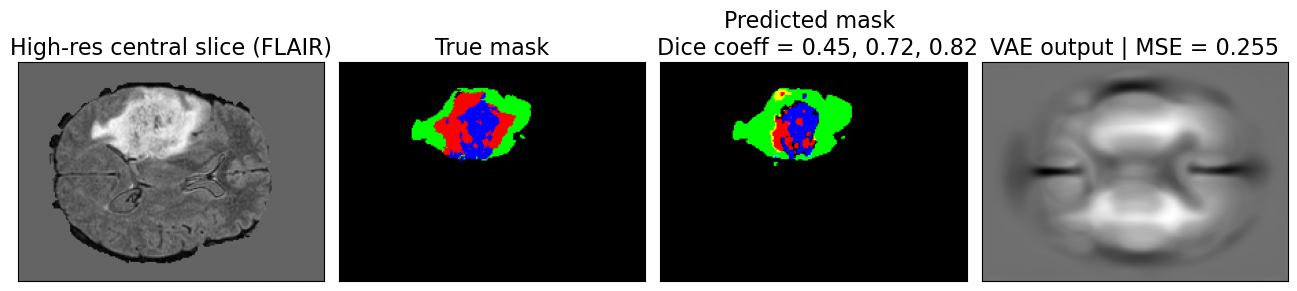

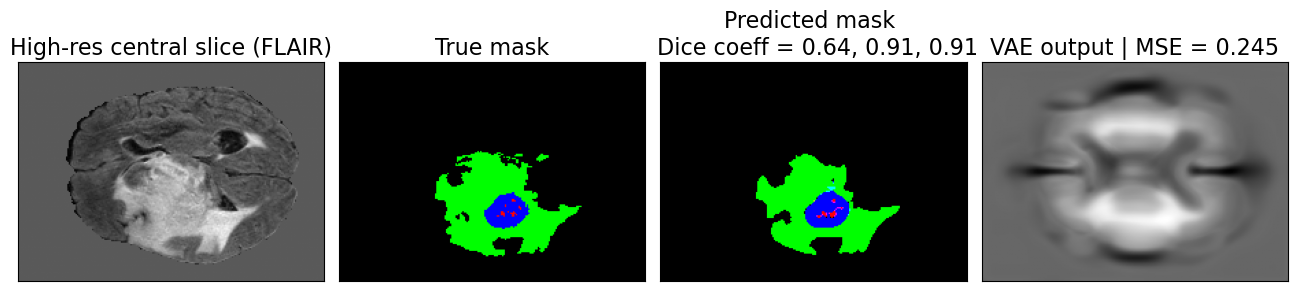

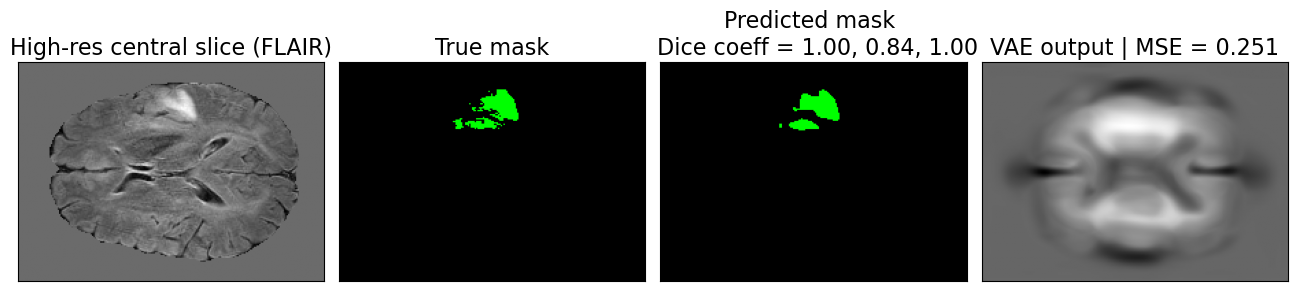

In [3]:

device = 'cuda'
np.random.seed(42)

params = DataParams()
data_examples = BRATS_dataset(Path("demo_data"), device, params)

model = load_model("REF").to(device)
model.load_state_dict(torch.load("demo_data/model_weights_0.pt"))

plot_indices = [2,0,1] #Images to plot
plot_examples_demo(model, data_examples, plot_indices)

### Example 2: Asymmetrical network with downsampled inputs and no VAE

For the second example, we use the asymmetrical network trained with inputs downsampled by a factor of 2 using bilinear interpolation. This is an ablation that does not use the VAE. We found that, in this case, the VAE branch does not improve results. 
Because of the downsampling, we expected results to be worse than for example 1. But we found that the performance decreases slightly, but not significantly.

Plotting results------------------------------------------------------------


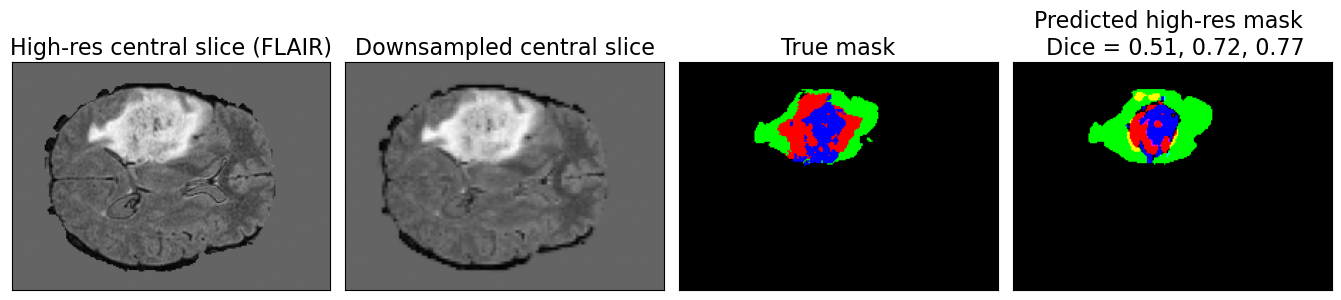

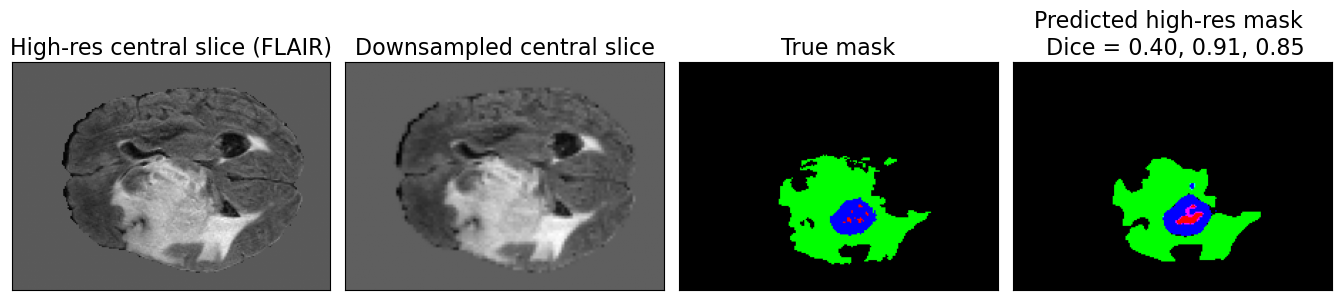

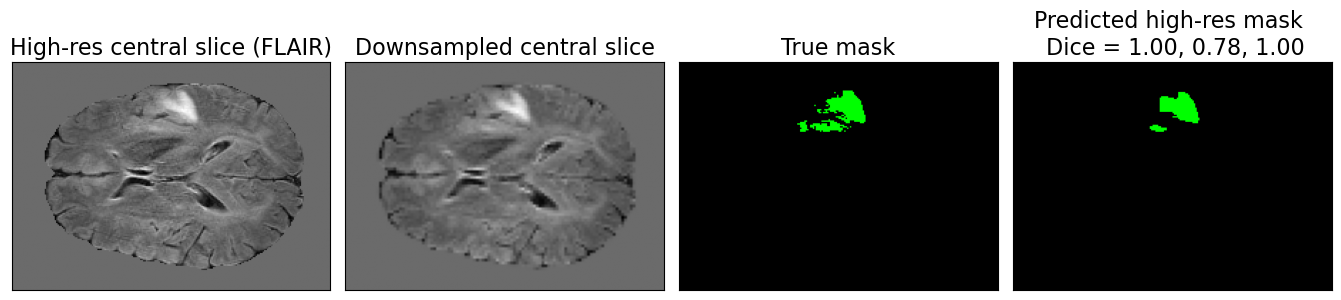

In [4]:

np.random.seed(42)
params = DataParams(ds_ratio = 2)
data_examples = BRATS_dataset(Path("demo_data"), device, params)


model = load_model("VAE_3D", VAE_enable = False).to(device)
model.load_state_dict(torch.load("demo_data/model_weights_1.pt"))

plot_examples_demo(model, data_examples, plot_indices, VAE_enable = False)

### Example 3: Asymmetrical network with downsampled inputs and with VAE

For the third example, we use the same architecture and input dimension as example 2, but with the VAE branch. This specific model was selected after tuning the relative weights between the MSE and KL divergence loss of the VAE. We found that a lower MSE and much lower KL divergence improved results. In this case, the weight of the MSE is 0.01, and of the KL divergence 0.001.
Interestingly, the output is extremely blurry but seems to be lighter around the region where the tumor is located. This is not always the case, and running multiple times might lead to different results because of the randomness in the VAE sampling, but we observed this to be the case in most runs.

Plotting results------------------------------------------------------------


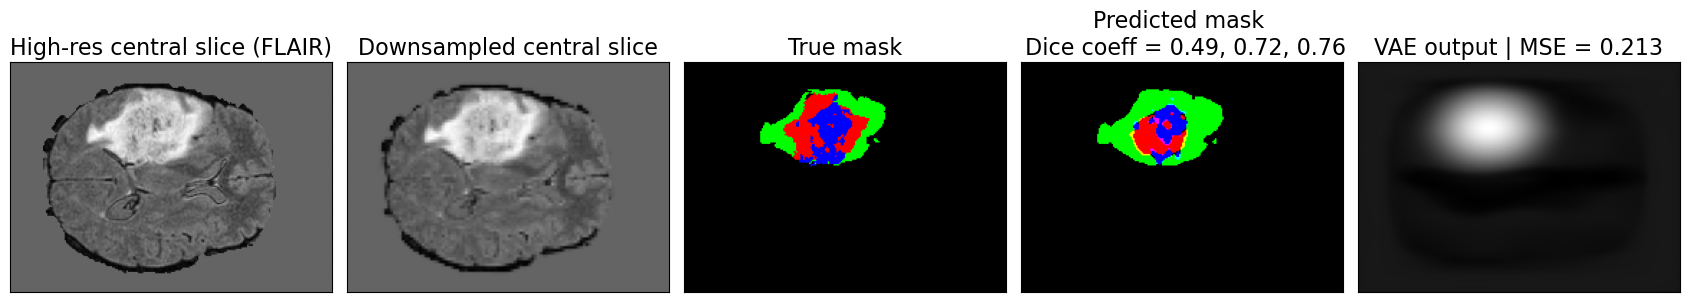

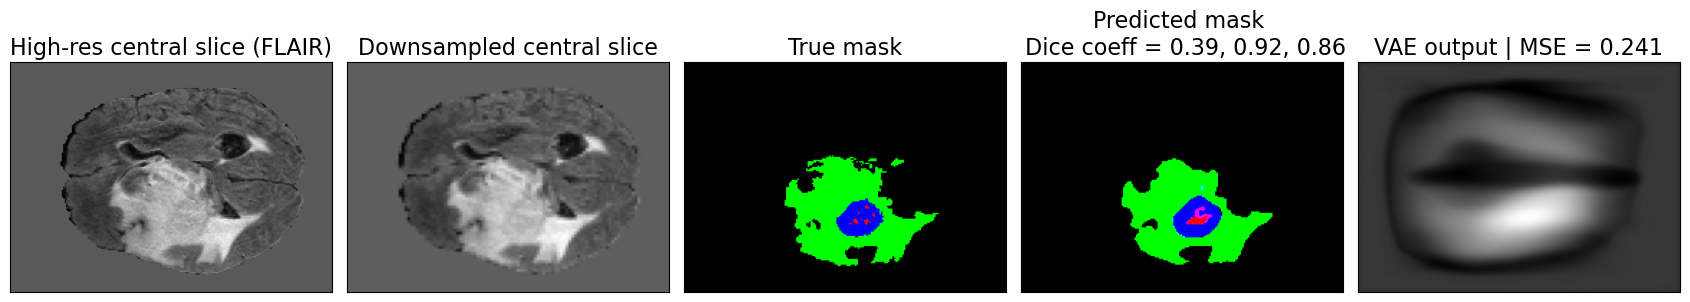

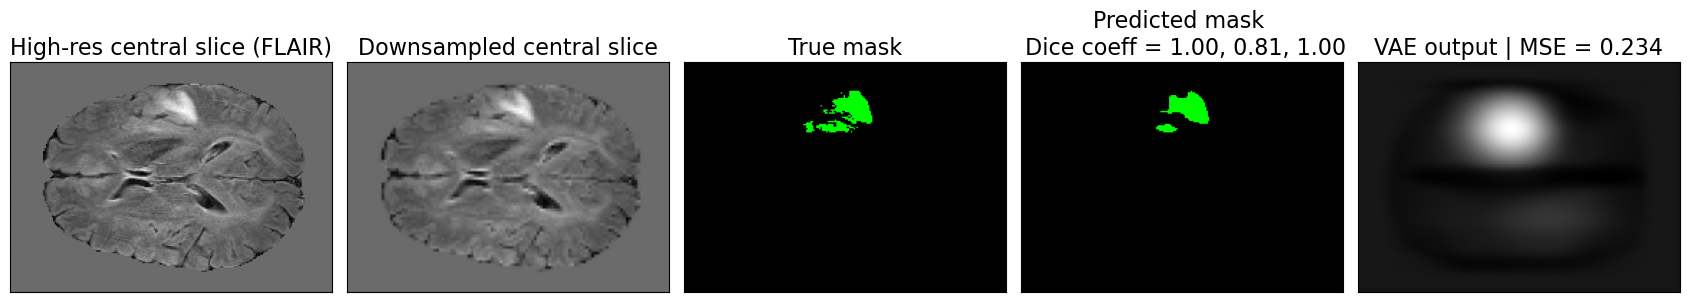

In [5]:

np.random.seed(42)
params = DataParams(ds_ratio = 2)
data_examples = BRATS_dataset(Path("demo_data"), device, params)

model = load_model("VAE_3D", VAE_enable = True).to(device)
model.load_state_dict(torch.load("demo_data/model_weights_2.pt"))

plot_examples_demo(model, data_examples, plot_indices)